# Predicting continuous target variables with Regression Analysis

Regression models are used to predict target variables on a continuous scale, whcih makes them attractive for addressing many questions in science as well as applications in industry, such as understanding the relationship between variables, evaluating trends, or making forecasts. One examle would be predicting the sales of a company in future months.  
In this chapter we'll cover the following topics:  
* Exploring and visualizing datasets
* Looking at different approaches to implement linear Regression models
* Training regression models that are robust to outliers
* Evaluating regression models and diagnosing common problems
* Fitting regression models to nonlinear data

## Exploring the Housing Dataset

This dataset contains information about houses in the
suburbs of Boston collected by D. Harrison and D.L. Rubinfeld in 1978. The Housing
Dataset has been made freely available and can be downloaded from the UCI machine
learning repository at https://archive.ics.uci.edu/ml/datasets/Housing

Attributes:

1. CRIM:      per capita crime rate by town
2. ZN:        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS:     proportion of non-retail business acres per town
4. CHAS:      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX:       nitric oxides concentration (parts per 10 million)
6. RM:        average number of rooms per dwelling
7. AGE:       proportion of owner-occupied units built prior to 1940
8. DIS:       weighted distances to five Boston employment centres
9. RAD:       index of accessibility to radial highways
10. TAX:      full-value property-tax rate per 10,000 dollar 
11. PTRATIO:  pupil-teacher ratio by town
12. B:        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT:    pecentage lower status of the population
14. MEDV:     Median value of owner-occupied homes in 1000's dollars


In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


We will regard the housing prices (MEDV) as our
target variable—the variable that we want to predict using one or more of the 13
explanatory variables.

### Visualizing important characteristics of the dataset

Firstly we'll create a scatter plot matrix to visualize the pair wise relationship between different features of the dataset in one place.

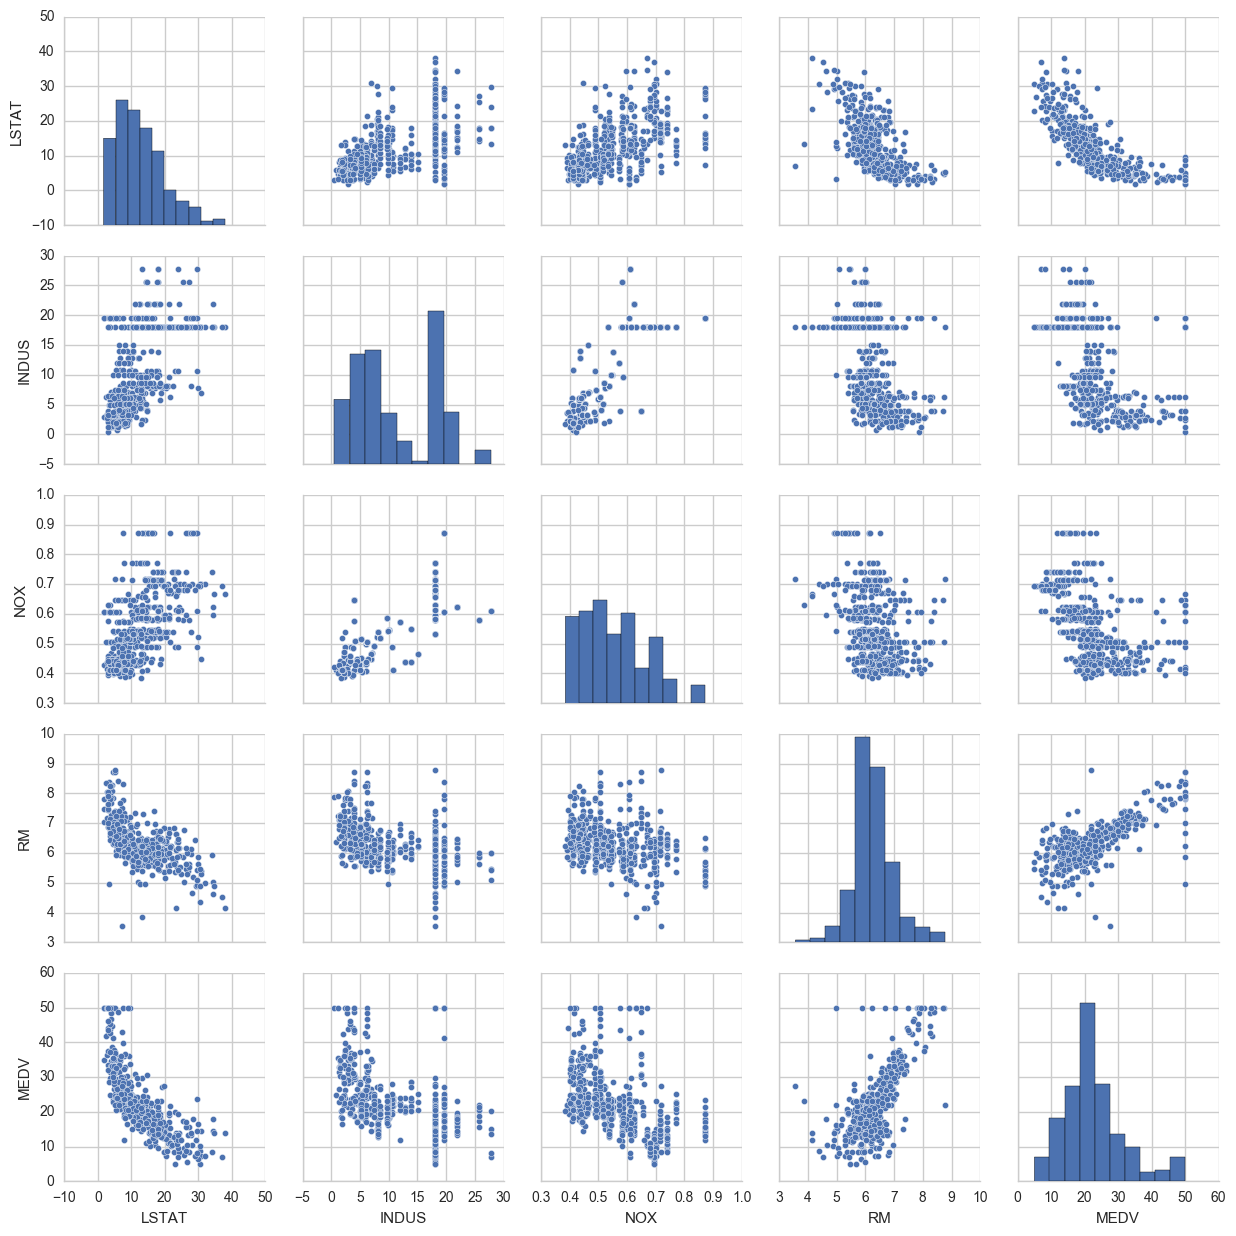

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.show()

We can see that there is a linear relationship between RM and MEDV, we can also see in the histogram that MEDV seems to be normally distributed but contains several outliers.

In the following code we'll use NumPy's corrcoef function on the five feature columns that we previously visualized in the scatterplot matrix, we'll use seaborn's heatmap function to plot the correlation matrix array as a heatmap.

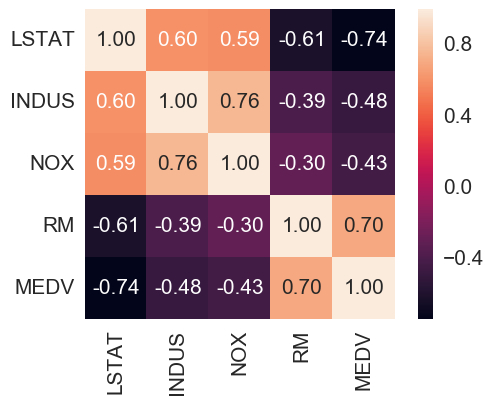

In [3]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=cols,
                xticklabels=cols)
plt.show()

To fit a linear regression model we are interested in features which have a high correlation with our target variable MEDV, from the heatmap we can clearly see that MEDV shows the largest correlation with LSTAT (-0.74). But if we remember from the scatter plot, there is a clear non linear relationship between MEDV and LSTAT. On the other hand the correlation between MEDV and RM is also very high (0.70) and given the linear relationship between the two from the scatterplot matrix, RM seems to be a good choice for fitting a linear regression model.

### Solving regression for regression parameters with gradient descent

OLS(Ordinary Least Squares) regression can be understood as Adaline without unit step function so that we obtain continuous target values instead of class labels -1 and 1. 

In [41]:
# Let's use the gradient descent implementation of Adaline from chapter 2 and remove the unit step function 
# to implement our first linear regression model

class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)


To see the LinearRegressionGD in action, let's use RM(number of rooms) as the explanatory variable to train a model that can predict MEDV. We'll standardize the variables for better convergence of the GD algorithm.

In [42]:
X = df[['RM']].values
y = df['MEDV'].values

In [43]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [44]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

It is always a good idea to plot the cost function for the number of epochs when we are using an optimization algorithm such as gradient descent, to check for convergence. Let's plot the cost fuction against the number of epochs.

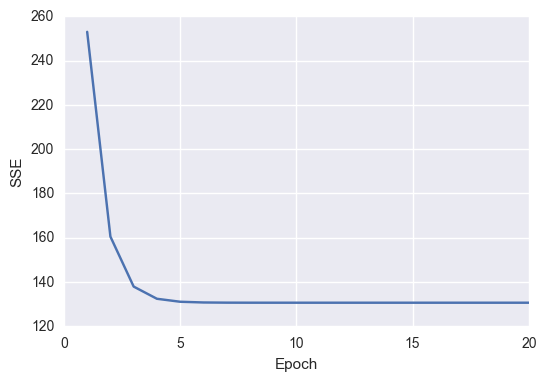

In [49]:
sns.set(font_scale=1)
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

Now, we can see that the GD algorithm converged after the fifth epoch.

Next, let's visualize how well the linear regression line fits the training data.

In [59]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red')
    return None


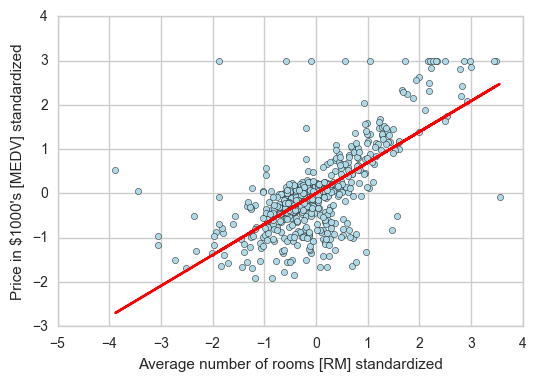

In [61]:
sns.set(style='whitegrid')
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] standardized')
plt.ylabel('Price in $1000\'s [MEDV] standardized')
plt.show()

Although this observation makes intuitive sense, the data also tells us that the
number of rooms does not explain the house prices very well in many cases.Interestingly, we also observe a curious line y = 3 , which suggests that the
prices may have been clipped.

To scale the predicted
price outcome back on the Price in $1000's axes, we can simply apply the
inverse_transform method of the StandardScaler:

In [57]:
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


In [58]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


### Evaluating the coefficient of a regression model via scikit learn

In real world applications we may be interested in more efficient implementations, for example scikit-learn's LinearRegression object that makes use of LIBLINEAR library and advanced optimization algorithms that work better with unstandardized variables.

In [62]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f'%slr.coef_[0])
print('Intercept: %.3f'%slr.intercept_)

Slope: 9.102
Intercept: -34.671


### Fitting a robust regression model using RANSAC

As an alternative to throwing out outliers, we will look at a robust method of
regression using the RANdom SAmple Consensus (RANSAC) algorithm,
which fits a regression model to a subset of the data, the so-called inliers.
We can summarize the iterative RANSAC algorithm as follows:
1.	 Select a random number of samples to be inliers and fit the model.
2.	 Test all other data points against the fitted model and add those points
that fall within a user-given tolerance to the inliers.
3.	 Refit the model using all inliers.
4.	 Estimate the error of the fitted model versus the inliers.
5.	 Terminate the algorithm if the performance meets a certain user-defined
threshold or if a fixed number of iterations has been reached; go back to
step 1 otherwise.


In [63]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                        residual_threshold=5.0,
                        random_state=0)
ransac.fit(X,y)

/home/piyush/.local/lib/python3.5/site-packages/sklearn/linear_model/ransac.py:288: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x7f92842f96a8>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

After we have fitted the RANSAC model, let's obtain the inliers and outliers from the
fitted RANSAC linear regression model and plot them together with the linear fit:

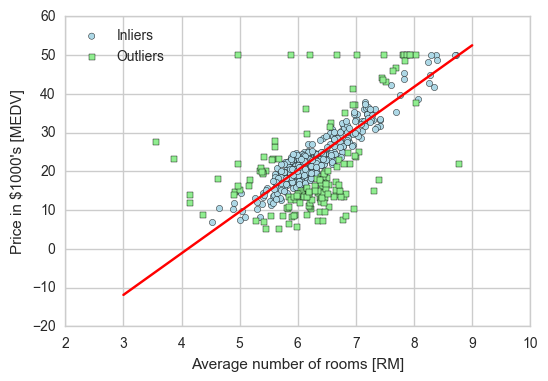

In [68]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask], c='lightblue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [69]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


We see the slope and the intercept for the ransac model is slightly different from what we got using simple Linear Regression without RANSAC, using RACSAC we reduced the potential effect of outliers in this dataset but we don't know whether this effect has a positive effect on the predictive performance on unseen data.

### Evaluating performance of linear regression models

We want to split our dataset into separate training and
test datasets where we use the former to fit the model and the latter to evaluate its
performance to generalize to unseen data. Instead of proceeding with the simple
regression model, we will now use all variables in the dataset and train a multiple
regression model:

In [80]:
from sklearn.cross_validation import train_test_split
X = df.iloc[:, :-1].values
y= df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)



Since our model uses multiple explanatory variables, we can't visualize the linear
regression line (or hyperplane to be precise) in a two-dimensional plot, but we
can plot the residuals (the differences or vertical distances between the actual and
predicted values) versus the predicted values to diagnose our regression model.
Those residual plots are a commonly used graphical analysis for diagnosing
regression models to detect nonlinearity and outliers, and to check if the errors
are randomly distributed.

Using the following code, we will now plot a residual plot where we simply subtract
the true target variables from our predicted responses:

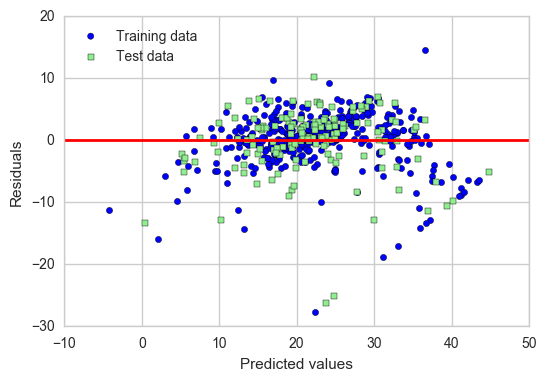

In [81]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error
print('MES train: %.3f, test: %.3f'%(mean_squared_error(y_train,y_train_pred),mean_squared_error(y_test,y_test_pred)))

MES train: 19.958, test: 27.196


We can see that the MSE for the test data is much larger than the training data which is an indicator of overfitting in the model.

Sometimes it may be useful to report the coefficient of determination (R squared), which can be uderstood as a standardized version of the MSE.

In [83]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f test: %.3f'%(r2_score(y_train,y_train_pred), r2_score(y_test, y_test_pred)))

R^2 train: 0.765 test: 0.673


Evaluated on the training data, the R 2 of our model is 0.765, which doesn't sound
too bad. However, the R 2 on the test dataset is only 0.673

### Using Regualrized methods for regression

As we discussed in Chapter 3, A Tour of Machine Learning Classifiers Using
Scikit-learn, regularization is one approach to tackle the problem of overfitting by
adding additional information, and thereby shrinking the parameter values of the
model to induce a penalty against complexity. The most popular approaches to
regularized linear regression are the so-called Ridge Regression, Least Absolute
Shrinkage and Selection Operator (LASSO) and Elastic Net method.

In [85]:
# ridge regression
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
# lasso
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
# Lastly, the ElasticNet implementation allows us to vary the L1 to L2 ratio:
from sklearn.linear_model import ElasticNet
el = ElasticNet(alpha=1.0, l1_ratio=0.5) #if we put l1_ratio equal to 1, then it would be equal to LASSO regression